In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: kaggle.json: No such file or directory
chmod: /Users/kaitlynli/.kaggle/kaggle.json: No such file or directory


In [3]:
!kaggle datasets download -d amitanshjoshi/spotify-1million-tracks

Dataset URL: https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks
License(s): ODbL-1.0
spotify-1million-tracks.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip spotify-1million-tracks.zip -d /mnt/data/

Archive:  spotify-1million-tracks.zip
checkdir:  cannot create extraction directory: /mnt/data
           No such file or directory


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# tracks = pd.read_csv('/mnt/data/spotify_data.csv')
tracks = pd.read_csv('../spotify_data.csv')
tracks['genre'] = tracks['genre'].str.strip().str.lower()
tracks.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)
tracks.dropna()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,1473391,Nicola Conte,Black Spirits,0m27F0IGHLGAWhqd6ccYst,4,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3
1159760,1473392,Nicola Conte,Quiet Dawn,6er9p611eHEcUCU50j7D57,3,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4
1159761,1473393,Amon Tobin,Morning Ms Candis,7jsMMqxy1tt0rH5FzYcZTQ,2,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4
1159762,1473394,Peace Orchestra,Happy Christmas (War Is Over),77lA1InUaXztuRk2vOzD1S,0,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3


In [5]:
# features for clustering
features = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_ms', 'time_signature']

# standardize feature cols
scaler = StandardScaler()
scaledTracks = scaler.fit_transform(tracks[features])

dbscan = DBSCAN(eps=0.7, min_samples=7)
tracks['cluster'] = dbscan.fit_predict(scaledTracks)

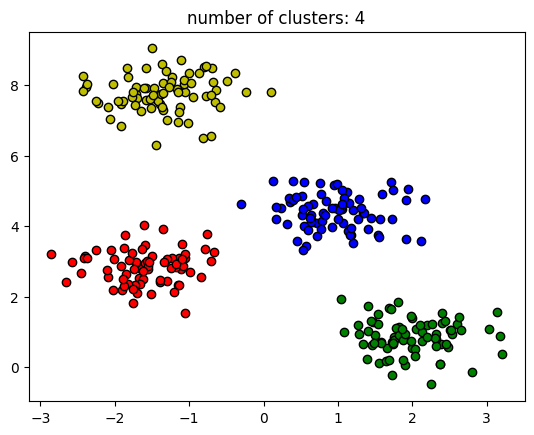

In [6]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.50, random_state=0)
dbscan.fit(X)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
 
# number of clusters in labels
# ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
 
    class_member_mask = (labels == k)
 
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)
 
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)
 
plt.title('number of clusters: %d' % n_clusters_)
plt.show()

In [24]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise

def calculate_clustering_metrics(tracks, model, clusters):

    labels = model.labels_

    silhouette = silhouette_score(tracks, labels)
    davies_bouldin = davies_bouldin_score(tracks, labels)
    calinski_harabasz = calinski_harabasz_score(tracks, labels)
    cosine_similarities = []
    for cluster in range(clusters):
        cluster_points = tracks[labels == cluster]
        if len(cluster_points) > 1:
            similarity = pairwise.cosine_similarity(cluster_points).mean()
            cosine_similarities.append(similarity)
    average_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)

    return {
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin,
        'calinski_harabasz_score': calinski_harabasz,
        'average_cosine_similarity': average_cosine_similarity
    }

# calculate clustering metrics
metrics = calculate_clustering_metrics(scaledTracks[1:301], dbscan, len(set(labels)) - (1 if -1 in labels else 0))
print("Clustering Metrics:")
print(metrics)


Clustering Metrics:
{'silhouette_score': -0.027183992596153044, 'davies_bouldin_score': 11.524808476158043, 'calinski_harabasz_score': 1.3453061111059403, 'average_cosine_similarity': 0.17178206495862436}


In [7]:
def recommendSongs(inputTrackName, inputArtistName, tracks, features, scaler, dbscan, n_recommendations=10):
    inputTrackName = inputTrackName.strip().lower()
    inputArtistName = inputArtistName.strip().lower()

    # find input track
    inputTrack = tracks[(tracks['track_name'].str.lower() == inputTrackName) & (tracks['artist_name'].str.lower() == inputArtistName)]

    if inputTrack.empty:
        print("Track not found in dataset")
        return pd.DataFrame()
    
    print("Input track found:")
    print(inputTrack)

    inputTrackFeatures = inputTrack[features]
    scaledInputTrackFeatures = scaler.transform(inputTrackFeatures)

    # get cluster of the input track
    inputCluster = inputTrack['cluster'].values[0]
    print(f"Predicted cluster: {inputCluster}")

    if inputCluster == -1:
        print("The input track is considered noise by DBSCAN and does not belong to any cluster.")
        return pd.DataFrame()

    # get tracks from the same cluster
    similarTracks = tracks[tracks['cluster'] == inputCluster]
    similarTracks = similarTracks[(similarTracks['track_name'].str.lower() != inputTrackName) | (similarTracks['artist_name'].str.lower() != inputArtistName)]

    # calculate the distances to input track
    similarTracksFeatures = scaler.transform(similarTracks[features])
    distances = euclidean_distances(scaledInputTrackFeatures, similarTracksFeatures).flatten()
    similarTracks['distance'] = distances

    # sort by distance and select top n_recommendations
    recommendations = similarTracks.sort_values(by=['distance', 'popularity'], ascending=[True, False]).drop_duplicates(subset=['artist_name', 'track_name']).head(n_recommendations)

    if len(recommendations) < n_recommendations:
        remaining = similarTracks[~similarTracks.index.isin(recommendations.index)].head(n_recommendations - len(recommendations))
        recommendations = pd.concat([recommendations, remaining])

    return recommendations[['artist_name', 'track_name', 'popularity', 'genre', 'year']]

inputTrackName = input("Enter track name: ")
inputArtistName = input("Enter artist name: ")
recommendations = recommendSongs(inputTrackName, inputArtistName, tracks, features, scaler, dbscan)

if recommendations.empty:
    print("No recommendations found")
else:
    print("Here are the top recommendations based on the inputted song:")
    print(recommendations[['artist_name', 'track_name', 'popularity', 'genre', 'year']])

Input track found:
        Unnamed: 0 artist_name track_name                track_id  popularity  \
461992      461992  The Weeknd  Heartless  6bnF93Rx87YqUBLSgjiMU8          84   

        year genre  danceability  energy  key  ...  mode  speechiness  \
461992  2020   pop         0.537   0.746   10  ...     0         0.15   

        acousticness  instrumentalness  liveness  valence    tempo  \
461992        0.0236          0.000001     0.156    0.252  170.062   

        duration_ms  time_signature  cluster  
461992       198267               4        2  

[1 rows x 21 columns]
Predicted cluster: 2
Here are the top recommendations based on the inputted song:
              artist_name                               track_name  \
1138676         The Roots                               I Remember   
85914             J. Cole                             Miss America   
447065   The Crabb Family             Sister, Play That Tambourine   
878330             C.P.V.                          

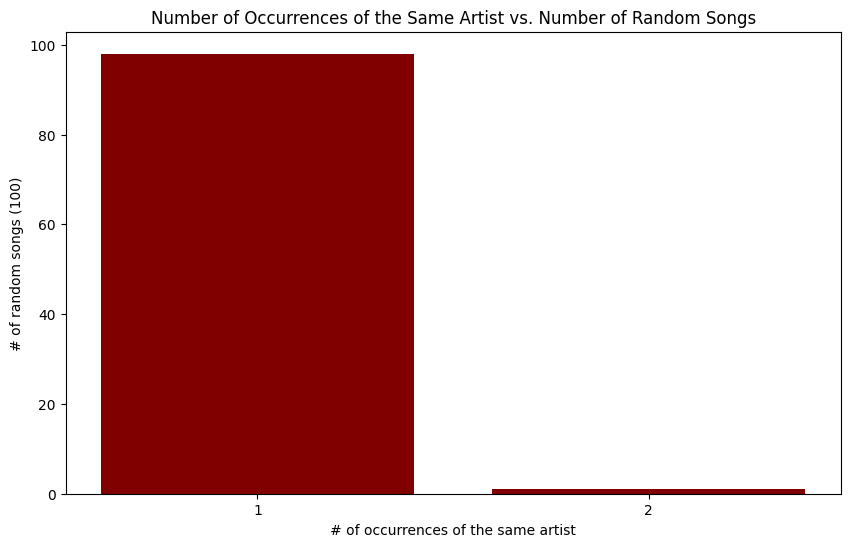

In [17]:
NUM_SAMPLES = 100
artist_occurrences = {}

# 100 rando songs
sampled_indices = np.random.choice(tracks.index, NUM_SAMPLES, replace=False)
sampled_tracks = tracks.loc[sampled_indices]

# count occurrences of each artist within the sampled tracks
for artist in sampled_tracks['artist_name']:
    if artist not in artist_occurrences:
        artist_occurrences[artist] = 0
    artist_occurrences[artist] += 1

# count how many artists appear a certain number of times
same_artist_count = {}
for count in artist_occurrences.values():
    if count not in same_artist_count:
        same_artist_count[count] = 0
    same_artist_count[count] += 1

x_values = list(same_artist_count.keys())  # # of occurrences of the same artist
y_values = list(same_artist_count.values())  # freq of each occurrence count

plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='maroon')
plt.xlabel("# of occurrences of the same artist")
plt.ylabel("# of random songs (100)")
plt.title("Number of Occurrences of the Same Artist vs. Number of Random Songs")
plt.xticks(np.arange(min(x_values), max(x_values)+1))

plt.show()


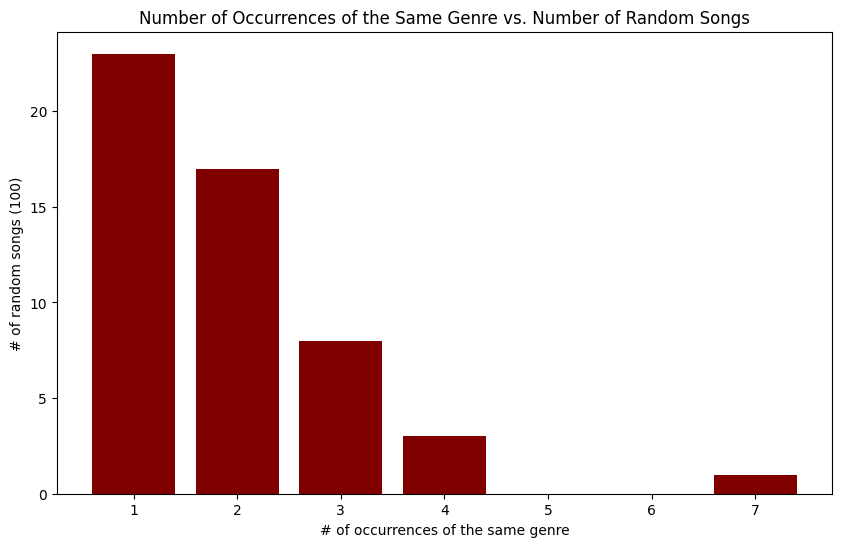

In [35]:
NUM_SAMPLES = 100
genre_occurrences = {}

# 100 rando songs
sampled_indices = np.random.choice(tracks.index, NUM_SAMPLES, replace=False)
sampled_tracks = tracks.loc[sampled_indices]

# count occurrences of each genre within the sampled tracks
for genre in sampled_tracks['genre']:
    if genre not in genre_occurrences:
        genre_occurrences[genre] = 0
    genre_occurrences[genre] += 1

# count how many genre appear a certain number of times
same_genre_count = {}
for count in genre_occurrences.values():
    if count not in same_genre_count:
        same_genre_count[count] = 0
    same_genre_count[count] += 1

x_values = list(same_genre_count.keys())  # # of occurrences of the same genre
y_values = list(same_genre_count.values())  # freq of each occurrence count

plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='maroon')
plt.xlabel("# of occurrences of the same genre")
plt.ylabel("# of random songs (100)")
plt.title("Number of Occurrences of the Same Genre vs. Number of Random Songs")
plt.xticks(np.arange(min(x_values), max(x_values)+1))

plt.show()
